## imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import desispec.io

## data

In [2]:
redux = '/global/cfs/cdirs/desi/spectro/redux'
def filepath(specprod, night, expid, kind, camera):
    return f'{redux}/{specprod}/exposures/{night}/{expid:08d}/{kind}-{camera}-{expid:08d}.fits'

In [3]:
night = "20210319"
expid = 81059
kind = "frame"
camera = "z1"

From a cori login node, start an interactive session on a Cori GPU node:

```
module purge
module load cgpu

salloc -C gpu -N 1 -G 4 -c 40 -t 120

module load python cuda/11.1.1 gcc openmpi

#- assume you have setup a conda env on cori gpu with gpu_specter + deps
#- ...

source activate $CONDA_ENV

export OMP_NUM_THREADS=1

```

Define set of extractions to perform:

In [4]:
run_list = [
    dict(source="specter", nsubbundles=6, nwavestep=50, use_gpu=False),
    dict(source="specter", nsubbundles=5, nwavestep=50, use_gpu=False),
    dict(source="specter", nsubbundles=5, nwavestep=200, use_gpu=False),
    dict(source="gpuspecter", nsubbundles=5, nwavestep=200, use_gpu=False),
    dict(source="gpuspecter", nsubbundles=5, nwavestep=200, use_gpu=True),
    dict(source="gpuspecter", nsubbundles=5, nwavestep=50, use_gpu=True),
]

Generate commands to run:

In [5]:
for run in run_list:
    source = run['source']
    nsubbundles = run['nsubbundles']
    nwavestep = run['nwavestep']
    use_gpu = run['use_gpu']
    cpu_or_gpu = 'gpu' if run['use_gpu'] else 'cpu'
    name = f"{source}-nsub{nsubbundles}-nwave{nwavestep}-{cpu_or_gpu}"
    run['name'] = name
    addargs = [
        f"--nsubbundles {nsubbundles}",
        f"--nwavestep {nwavestep}",
    ]
    if source == 'specter':
        addargs.append('--cpu-specter')
    if use_gpu:
        addargs.append('--gpu')
        
    #- Assume we are using half of a Cori GPU node
    #- salloc -C gpu -N 1 -G 4 -c 40 -t 120
    if use_gpu:
        srun = 'srun -n 8 -c 2 --cpu-bind=cores desi_mps_wrapper desi_benchmark_extract'
    else:
        srun = 'srun -n 20 -c 2 --cpu-bind=cores desi_benchmark_extract'
        
    filename = filepath(os.path.join('${USER}', 'compare-${SLURM_JOB_ID}', name), night, expid, kind, camera)
    
    baseargs = [
        '${INDIR}',
        '${OUTDIR}',
        '$(date +%s.%N)',
        f'--night {night}',
        f'--expid {int(expid):08d}',
        f'--cameras {camera}',
        '--barycentric-correction',
        '--pixpad-frac 0.8',
        '--wavepad-frac 0.2',
    ]
    
    print(f"#- {name}")
    print(f"INDIR={os.path.join(redux, 'denali')}")
    print(f"OUTDIR={os.path.dirname(filename)}")
    print("mkdir -p ${OUTDIR}")
    print(" ".join([srun] + baseargs + addargs))
    print()

#- specter-nsub6-nwave50-cpu
INDIR=/global/cfs/cdirs/desi/spectro/redux/denali
OUTDIR=/global/cfs/cdirs/desi/spectro/redux/${USER}/compare-${SLURM_JOB_ID}/specter-nsub6-nwave50-cpu/exposures/20210319/00081059
mkdir -p ${OUTDIR}
srun -n 20 -c 2 --cpu-bind=cores desi_benchmark_extract ${INDIR} ${OUTDIR} $(date +%s.%N) --night 20210319 --expid 00081059 --cameras z1 --barycentric-correction --pixpad-frac 0.8 --wavepad-frac 0.2 --nsubbundles 6 --nwavestep 50 --cpu-specter

#- specter-nsub5-nwave50-cpu
INDIR=/global/cfs/cdirs/desi/spectro/redux/denali
OUTDIR=/global/cfs/cdirs/desi/spectro/redux/${USER}/compare-${SLURM_JOB_ID}/specter-nsub5-nwave50-cpu/exposures/20210319/00081059
mkdir -p ${OUTDIR}
srun -n 20 -c 2 --cpu-bind=cores desi_benchmark_extract ${INDIR} ${OUTDIR} $(date +%s.%N) --night 20210319 --expid 00081059 --cameras z1 --barycentric-correction --pixpad-frac 0.8 --wavepad-frac 0.2 --nsubbundles 5 --nwavestep 50 --cpu-specter

#- specter-nsub5-nwave200-cpu
INDIR=/global/cfs/cdirs/

Fill in your username and the slurm jobid:

In [6]:
user = 'dmargala'
slurm_job_id = '2100506'
specprod_compare_base = f"{user}/compare-{slurm_job_id}"

Read frames and add to run list:

In [7]:
for run in run_list:
    name = run['name']
    specprod_run = f"{specprod_compare_base}/{name}"
    print(name)
    frame_run = desispec.io.read_frame(filepath(specprod_run, night, expid, kind, camera))
    run['specprod'] = specprod_run
    run['frame'] = frame_run

specter-nsub6-nwave50-cpu
INFO:frame.py:220:read_frame: iotime 0.596 sec to read frame-z1-00081059.fits at 2021-07-23T14:43:59.659134
specter-nsub5-nwave50-cpu
INFO:frame.py:220:read_frame: iotime 0.522 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:00.217083
specter-nsub5-nwave200-cpu
INFO:frame.py:220:read_frame: iotime 0.508 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:00.757756
gpuspecter-nsub5-nwave200-cpu
INFO:frame.py:220:read_frame: iotime 0.506 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:01.295213
gpuspecter-nsub5-nwave200-gpu
INFO:frame.py:220:read_frame: iotime 0.531 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:01.856977
gpuspecter-nsub5-nwave50-gpu
INFO:frame.py:220:read_frame: iotime 0.637 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:02.528747


Read in denali and everest too:

In [8]:
frame_denali = desispec.io.read_frame(filepath("denali", night, expid, kind, camera))
frame_everest = desispec.io.read_frame(filepath("everest", night, expid, kind, camera))

INFO:frame.py:220:read_frame: iotime 0.508 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:03.067896
INFO:frame.py:220:read_frame: iotime 0.529 sec to read frame-z1-00081059.fits at 2021-07-23T14:44:03.647261


Combine frames into a single list:

In [9]:
final_list = [
    dict(source="specter", nsubbundles=6, nwavestep=50, use_gpu=False, name='denali', specprod='denali', frame=frame_denali)
] + run_list + [
    dict(source="specter", nsubbundles=6, nwavestep=50, use_gpu=False, name='everest', specprod='everest', frame=frame_everest)
]

In [10]:
frames_df = pd.DataFrame(final_list)

## helpers

In [11]:
def plot_compare(f1, f2, plot_title=None):
    # compute dflux/err
    mask1 = (f1.mask > 0) | (f1.ivar == 0)
    mask2 = (f2.mask > 0) | (f2.ivar == 0)
    mask = mask1 | mask2
    var1 = np.reciprocal(~mask*f1.ivar + mask)
    var2 = np.reciprocal(~mask*f2.ivar + mask)
    ivar = np.reciprocal(~mask*(var1 + var2) + mask)
    dflux = f1.flux - f2.flux
    pull = ~mask*dflux*np.sqrt(ivar)

    medabspull = np.median(np.abs(pull), axis=0)
    maxabspull = np.max(np.abs(pull), axis=0)
    
    print(f"{np.max(np.abs(pull))=:.6g}")
    print(f"{np.sum(np.abs(pull) > 0.1)=}")
    print(f"{np.sum(np.max(np.abs(pull), axis=0) > 0.1)=}")

    fig, axes = plt.subplots(nrows=2, figsize=(14,6), constrained_layout=True)
    ax = axes[0]
    im = ax.imshow(pull, aspect='auto', vmin=-0.1, vmax=0.1, cmap='RdBu')
    ax.set_ylabel('fiber number')
    fig.colorbar(im, ax=ax)
    if plot_title:
        ax.set_title(plot_title)
    ax = axes[1]
    ax.plot(maxabspull, label='max(abspull)')
    ax.plot(medabspull, label='median(abspull)')
    ax.set_xlim(0, len(maxabspull))
    ax.set_ylim(-0.01, 0.1)
    ax.legend(loc='upper right')
    ax.set_xlabel('CCD row')
    ax.set_ylabel('max or med(|pull|)')    

In [12]:
def compare_frames(frames_df, index1, index2):
    print("Comparing frames: ")
    
    info_cols = ['source', 'nsubbundles', 'nwavestep', 'use_gpu', 'name']
    print(frames_df.iloc[[index1, index2]][info_cols])
    
    frames = frames_df["frame"]
    
    plot_compare(frames.iloc[index1], frames.iloc[index2])

In [13]:
plt.rcParams.update({'font.size': 14})

# frame

In [14]:
frames_df[['source', 'nsubbundles', 'nwavestep', 'use_gpu', 'name']]

,source,nsubbundles,nwavestep,use_gpu,name
0,specter,6,50,False,denali
1,specter,6,50,False,specter-nsub6-nwave50-cpu
2,specter,5,50,False,specter-nsub5-nwave50-cpu
3,specter,5,200,False,specter-nsub5-nwave200-cpu
4,gpuspecter,5,200,False,gpuspecter-nsub5-nwave200-cpu
5,gpuspecter,5,200,True,gpuspecter-nsub5-nwave200-gpu
6,gpuspecter,5,50,True,gpuspecter-nsub5-nwave50-gpu
7,specter,6,50,False,everest


## denali vs gpu_specter (gpu)

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                          name
0     specter            6         50    False                        denali
6  gpuspecter            5         50     True  gpuspecter-nsub5-nwave50-gpu
np.max(np.abs(pull))=0.39868
np.sum(np.abs(pull) > 0.1)=919
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=50


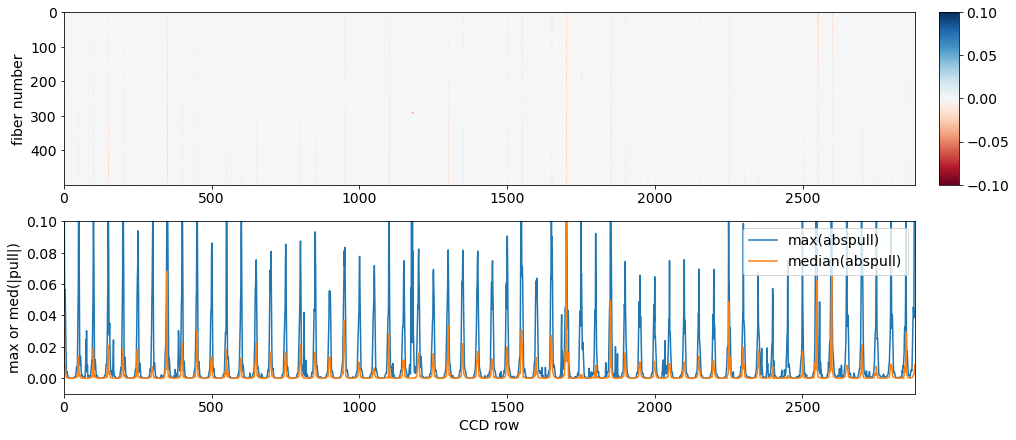

In [15]:
compare_frames(frames_df, 0, 6)

## denali vs specter

Try to reproduce denali result using my env

Comparing frames: 
    source  nsubbundles  nwavestep  use_gpu                       name
0  specter            6         50    False                     denali
1  specter            6         50    False  specter-nsub6-nwave50-cpu
np.max(np.abs(pull))=7.64989e-06
np.sum(np.abs(pull) > 0.1)=0
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=0


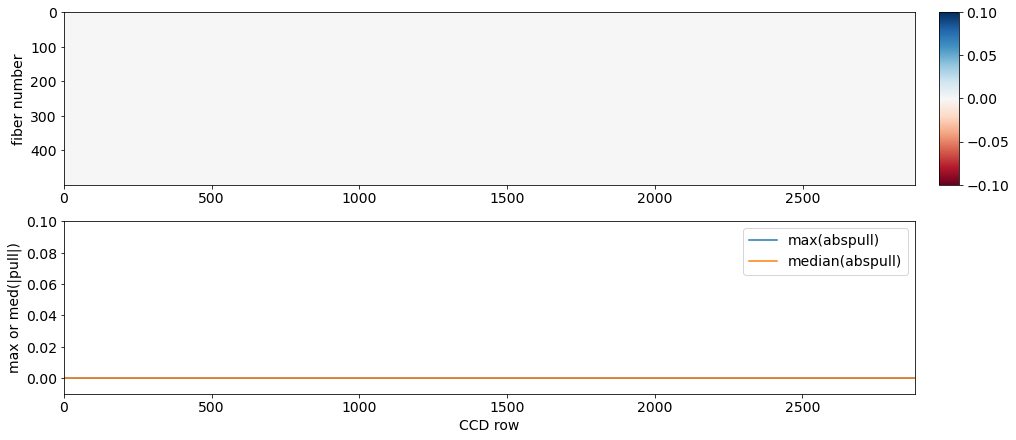

In [16]:
compare_frames(frames_df, 0, 1)

## change nsubbundles 6 -> 5

Comparing frames: 
    source  nsubbundles  nwavestep  use_gpu                       name
1  specter            6         50    False  specter-nsub6-nwave50-cpu
2  specter            5         50    False  specter-nsub5-nwave50-cpu
np.max(np.abs(pull))=0.36739
np.sum(np.abs(pull) > 0.1)=203
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=31


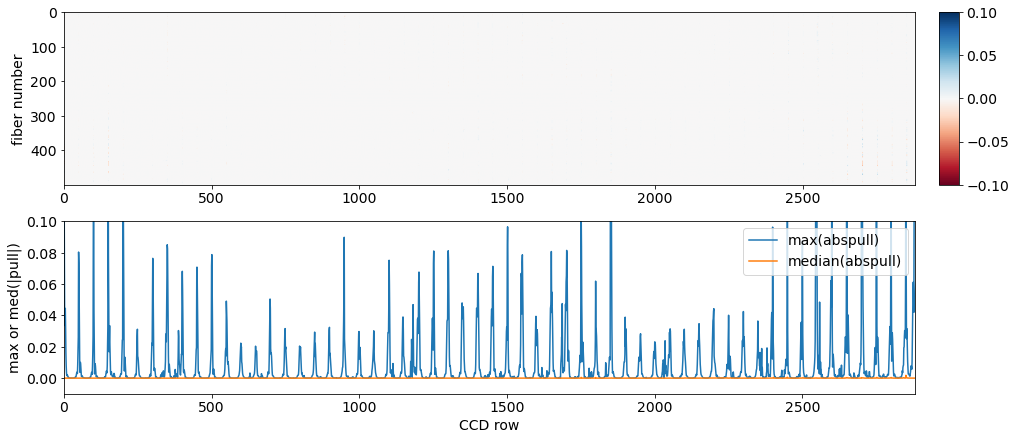

In [17]:
compare_frames(frames_df, 1, 2)

## change nwavestep 50 -> 200

Comparing frames: 
    source  nsubbundles  nwavestep  use_gpu                        name
2  specter            5         50    False   specter-nsub5-nwave50-cpu
3  specter            5        200    False  specter-nsub5-nwave200-cpu
np.max(np.abs(pull))=0.216486
np.sum(np.abs(pull) > 0.1)=103
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=18


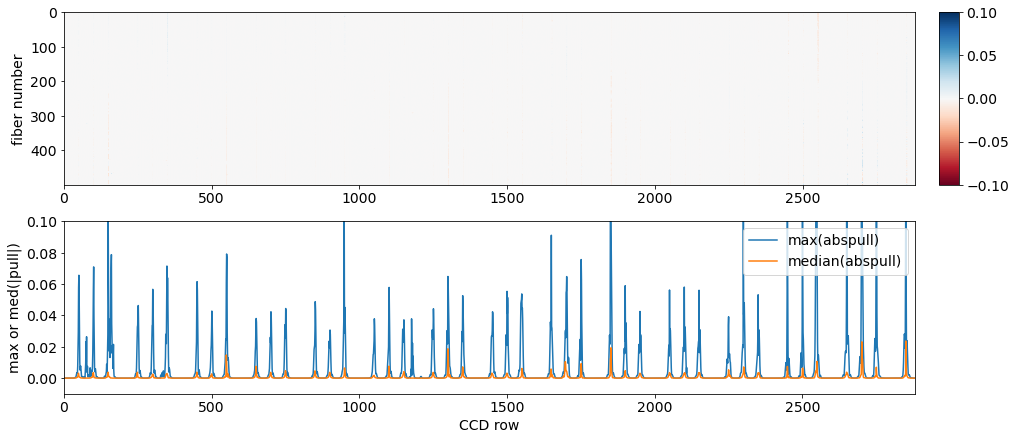

In [18]:
compare_frames(frames_df, 2, 3)

## compare cpu version of gpu_specter with specter

using nsubbundles=5 and nwavestep=200

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                           name
3     specter            5        200    False     specter-nsub5-nwave200-cpu
4  gpuspecter            5        200    False  gpuspecter-nsub5-nwave200-cpu
np.max(np.abs(pull))=0.33602
np.sum(np.abs(pull) > 0.1)=132
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=12


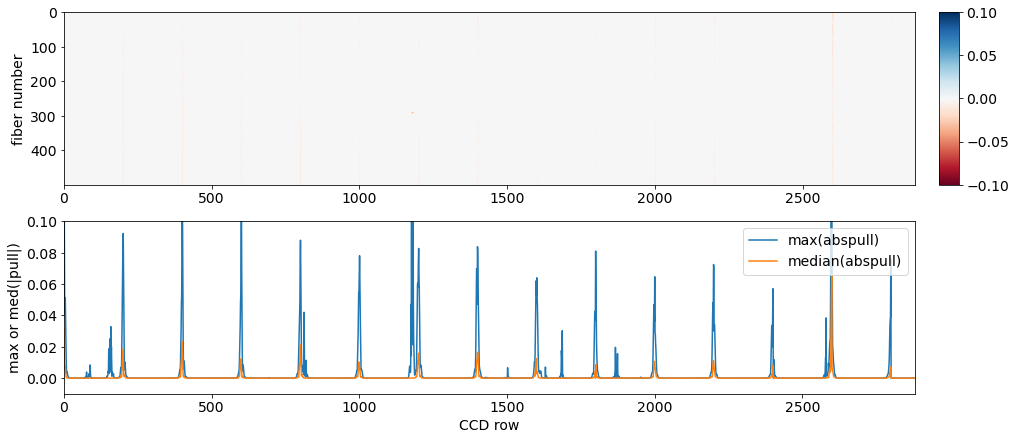

In [19]:
compare_frames(frames_df, 3, 4)

## compare cpu and gpu versions of gpu_specter

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                           name
4  gpuspecter            5        200    False  gpuspecter-nsub5-nwave200-cpu
5  gpuspecter            5        200     True  gpuspecter-nsub5-nwave200-gpu
np.max(np.abs(pull))=5.34311e-05
np.sum(np.abs(pull) > 0.1)=0
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=0


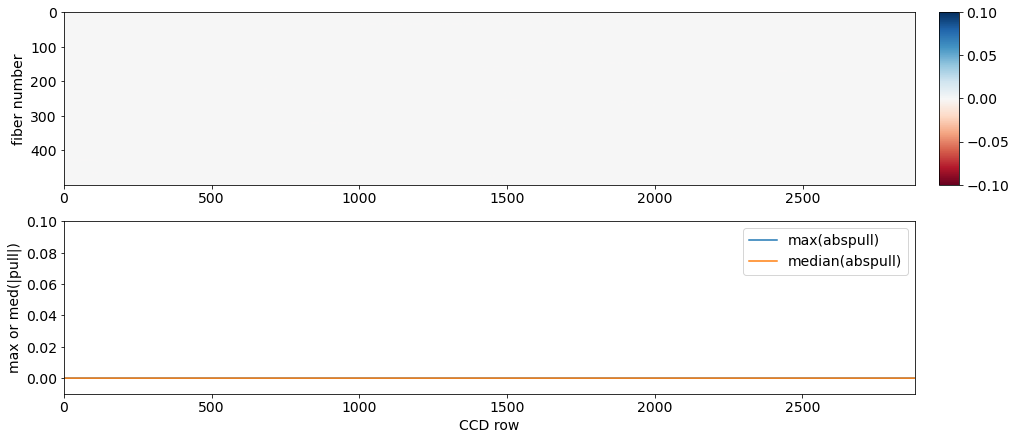

In [20]:
compare_frames(frames_df, 4, 5)

## change nwavestep 200 -> 50

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                           name
5  gpuspecter            5        200     True  gpuspecter-nsub5-nwave200-gpu
6  gpuspecter            5         50     True   gpuspecter-nsub5-nwave50-gpu
np.max(np.abs(pull))=0.299623
np.sum(np.abs(pull) > 0.1)=343
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=7


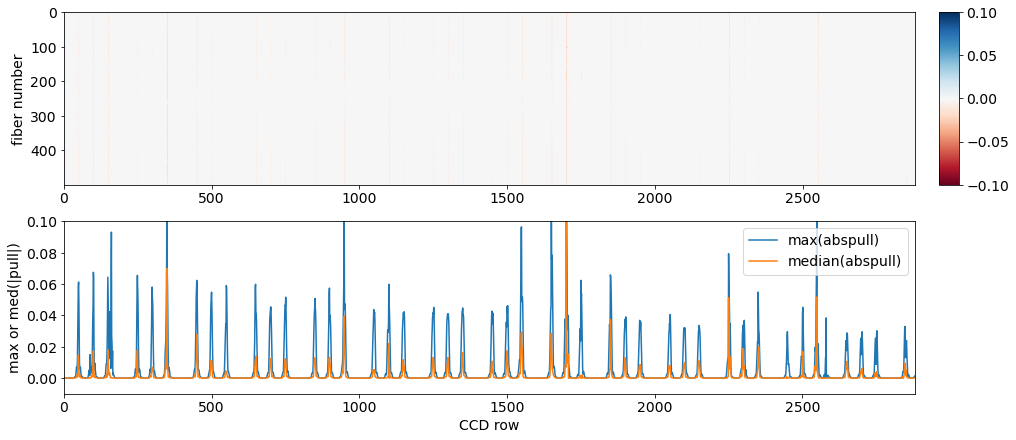

In [21]:
compare_frames(frames_df, 5, 6)

## specter vs gpu_specter (gpu) (same nsubbundles/nwavestep)

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                          name
2     specter            5         50    False     specter-nsub5-nwave50-cpu
6  gpuspecter            5         50     True  gpuspecter-nsub5-nwave50-gpu
np.max(np.abs(pull))=0.373863
np.sum(np.abs(pull) > 0.1)=949
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=50


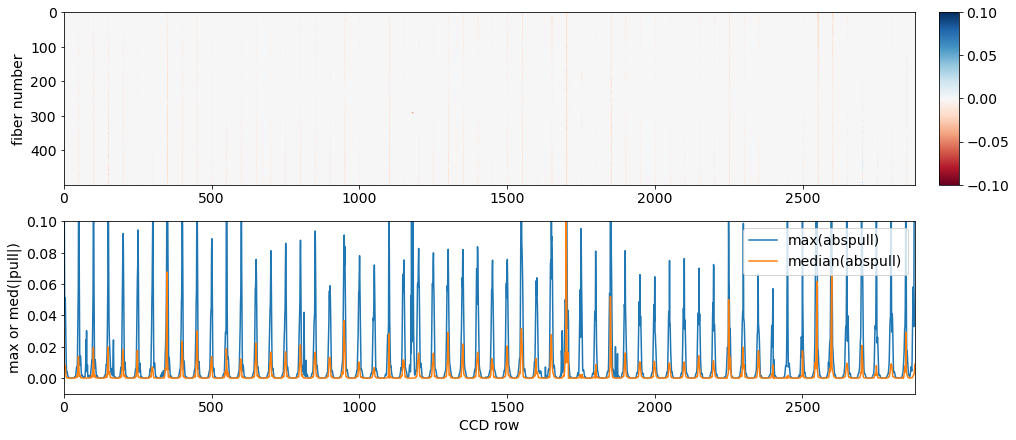

In [22]:
compare_frames(frames_df, 2, 6)

## denali vs everest

Comparing frames: 
    source  nsubbundles  nwavestep  use_gpu     name
0  specter            6         50    False   denali
7  specter            6         50    False  everest
np.max(np.abs(pull))=0.0460073
np.sum(np.abs(pull) > 0.1)=0
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=0


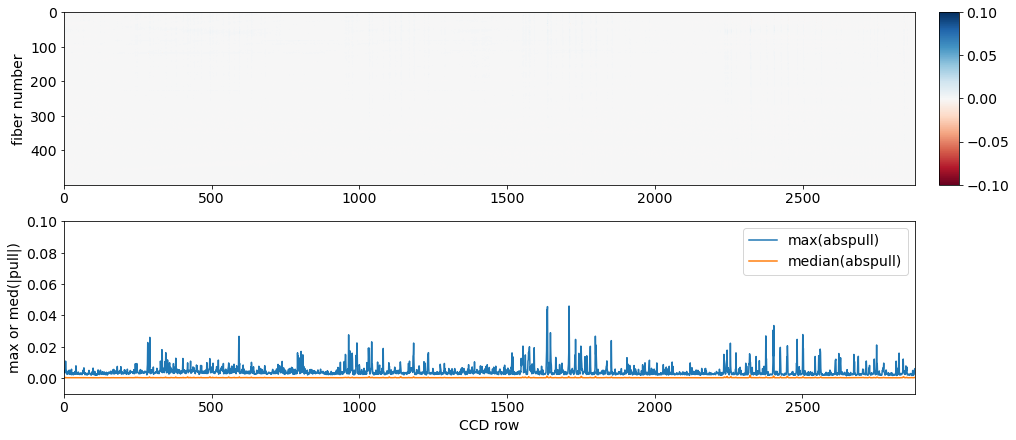

In [23]:
compare_frames(frames_df, 0, 7)

## everest vs gpu_specter

Comparing frames: 
       source  nsubbundles  nwavestep  use_gpu                          name
6  gpuspecter            5         50     True  gpuspecter-nsub5-nwave50-gpu
7     specter            6         50    False                       everest
np.max(np.abs(pull))=0.39783
np.sum(np.abs(pull) > 0.1)=923
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=52


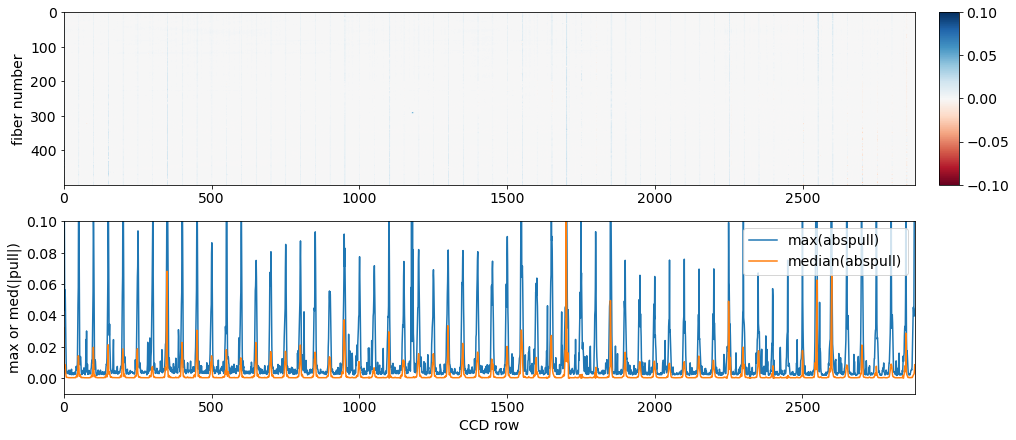

In [24]:
compare_frames(frames_df, 6, 7)

# cframe

In [25]:
cframe_denali = desispec.io.read_frame(filepath('denali', night, expid, 'cframe', camera))
cframe_everest = desispec.io.read_frame(filepath('everest', night, expid, 'cframe', camera))
# cframe_gpuspecter = desispec.io.read_frame(filepath('dmargala/32687', night, expid, 'cframe', camera))

INFO:frame.py:220:read_frame: iotime 0.504 sec to read cframe-z1-00081059.fits at 2021-07-23T14:44:12.295355
INFO:frame.py:220:read_frame: iotime 0.500 sec to read cframe-z1-00081059.fits at 2021-07-23T14:44:12.819183


np.max(np.abs(pull))=2.37022
np.sum(np.abs(pull) > 0.1)=44458
np.sum(np.max(np.abs(pull), axis=0) > 0.1)=2414


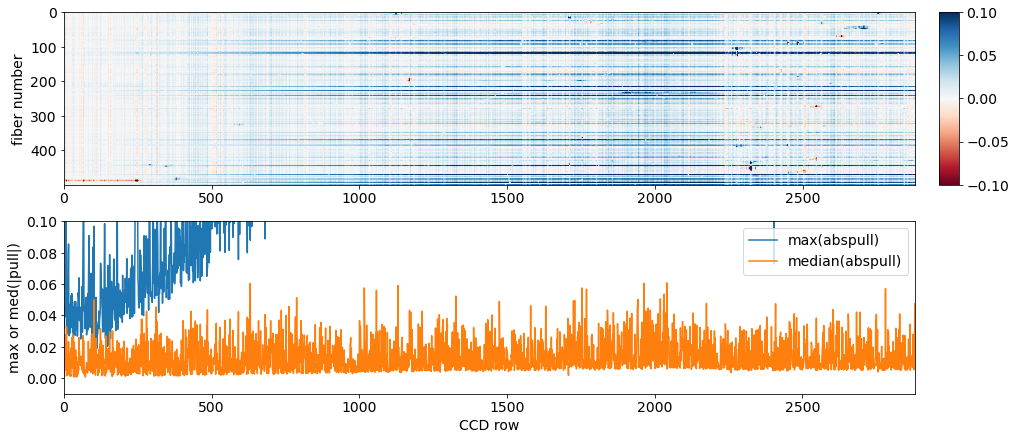

In [26]:
plot_compare(cframe_denali, cframe_everest)

In [27]:
# plot_compare(cframe_denali, cframe_gpuspecter)

In [28]:
# plot_compare(cframe_everest, cframe_gpuspecter)